In [1]:
import argparse
from datetime import datetime
import os
import pandas as pd

from utils import seed_everything, get_device, check_max_len, clean_gpu
from utils_config import get_model_config
from trainer import Trainer
from utils import prepare_datasets

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1
device = 0
target = 'mirna'
experiment_name = 'jupyter'
verbose=True

In [3]:
kmer=1

In [4]:
max_len = 1024
model_name = 'tthymba'
batch_size=32

d_model = 64
n_layer = 4
rc = False

is_pretrained = True

pooling_mode_target = 'Mean'
is_convblock=False
is_cross_attention=True
rna_model = 'rnabert'

load_pretrain_name='all_pt'

In [5]:
trainer = Trainer(
    seed=seed,
    device=device,
    experiment_name=experiment_name,
    verbose=verbose,
)

INFO:utils:Seeds set to 1.
✅ Logging setup complete.


In [6]:
max_len = check_max_len(max_len, model_name)
# df = pd.read_pickle(f'./data/df_final.pkl')
df = pd.read_pickle(f'./data/df_train_final.pkl')
df_test = pd.read_pickle(f'./data/df_test_final.pkl')

INFO:utils:Max length set to 1022 for model tthymba


In [7]:
df_extra = pd.concat([df, df_test]).reset_index(drop=True)

In [8]:
df['length'] = df['circRNA'].apply(len)
df_test['length'] = df_test['circRNA'].apply(len)
# df = df[df['length'] <= max_len]
# df_test = df_test[df_test['length'] <= max_len]

In [9]:
train_dataset, valid_dataset, test_dataset, extra_dataset = prepare_datasets(
        df=df, 
        df_test=df_test,
        max_len=max_len + 2,  # 2 for special tokens (CLS and EOS)
        target=target, 
        seed=seed,
        kmer=kmer,
        df_extra=df_extra,
    )

In [10]:
trainer.set_dataloader(train_dataset, part=0, batch_size=batch_size)
trainer.set_dataloader(valid_dataset, part=1, batch_size=batch_size)
trainer.set_dataloader(test_dataset, part=2, batch_size=batch_size)
trainer.set_dataloader(extra_dataset, part=3, batch_size=batch_size)

In [11]:
# Step 4. Configure Model
print('[Step 4] Configuring Model for training')
config = get_model_config(
    model_name=model_name,
    d_model=d_model,
    n_layer=n_layer,
    verbose=verbose,
    rc=rc,
    vocab_size=train_dataset.vocab_size
)

[Step 4] Configuring Model for training
- Model: tthymba
- d_model: 64
- n_layer: 4


In [12]:
trainer.define_model(
    config=config,
    model_name=model_name,
    pretrain=is_pretrained,
    pooling_mode_target=pooling_mode_target,
    is_convblock=is_convblock,
    is_cross_attention=is_cross_attention,
)

Model 'tthymba' initialized. Pretraining mode: True


In [13]:
trainer.set_pretrained_target(target=target, rna_model=rna_model)

Target model for mirna set with projection dimension 120


Target model for mirna set with projection dimension 120


In [14]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[ 2.1171, -0.8047, -0.4326,  ..., -0.1581,  0.7061,  0.7860],
        [ 1.2903,  0.4788,  0.7869,  ..., -0.7526,  0.3738,  1.8700],
        [-0.5223, -1.0558,  0.9727,  ..., -0.6165,  0.0953,  1.0375],
        ...,
        [ 0.5804,  0.9359, -0.6342,  ..., -1.2782,  0.4070,  1.6779],
        [ 0.4724, -0.4864, -0.2338,  ..., -1.2388,  0.8289,  2.7504],
        [ 1.5207, -1.5208,  0.2005,  ...,  0.9903,  0.7732,  2.1494]],
       device='cuda:0', requires_grad=True)

In [15]:
trainer.load_model(pretrain=False, load_pretrain_name=load_pretrain_name, verbose=True)

O Model state loaded successfully from ./saved_models/tthymba/all_pt/1/train/model.pth
X Warning: embedding file not found at ./saved_models/tthymba/all_pt/1/train/embedding.pth.
X Failed to load embedding from ./saved_models/tthymba/all_pt/1/train/embedding.pth. Skipping.
X Warning: backbone file not found at ./saved_models/tthymba/all_pt/1/train/backbone.pth.
X Failed to load backbone from ./saved_models/tthymba/all_pt/1/train/backbone.pth. Skipping.
X Warning: proj_target file not found at ./saved_models/tthymba/all_pt/1/train/proj_target.pth.
X Failed to load proj_target from ./saved_models/tthymba/all_pt/1/train/proj_target.pth. Skipping.
X Warning: convblock file not found at ./saved_models/tthymba/all_pt/1/train/convblock.pth.
X Failed to load convblock from ./saved_models/tthymba/all_pt/1/train/convblock.pth. Skipping.
X Warning: binding_head file not found at ./saved_models/tthymba/all_pt/1/train/binding_head.pth.
X Failed to load binding_head from ./saved_models/tthymba/all_p

In [16]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[ 2.9164, -0.8159,  0.0784,  ..., -0.7767,  0.8543,  0.4117],
        [ 1.2126,  0.6389,  0.9983,  ..., -0.6051,  0.7207,  1.7086],
        [-1.0025, -1.1945,  1.3165,  ..., -0.1657, -0.0379, -0.0962],
        ...,
        [ 0.5804,  0.9359, -0.6342,  ..., -1.2782,  0.4070,  1.6779],
        [ 0.4724, -0.4864, -0.2338,  ..., -1.2388,  0.8289,  2.7504],
        [ 1.5207, -1.5208,  0.2005,  ...,  0.9903,  0.7732,  2.1494]],
       device='cuda:0', requires_grad=True)

In [17]:
trainer.rc = False
trainer.task = 'both'
trainer.verbose = True

In [18]:
trainer.rc = False

In [19]:
trainer.task = 'both'

In [20]:
results = trainer.inference(data_loader=trainer.test_loader)
# results = trainer.inference(data_loader=trainer.extra_loader)

In [21]:
results.pop('lengths_sites')
df_results = pd.DataFrame(results)

In [22]:
import torch
import pandas as pd

def flatten_result_dict_per_sample(result_dict, sequences=None):
    """
    Converts nested result dict to a per-sample DataFrame.
    
    Parameters:
        result_dict: dict with keys ['binding', 'sites', 'lengths']
        sequences: optional list of circRNA sequence strings
    """
    # Unpack
    binding_logits = result_dict['binding'][0]     # list of [2] tensors
    site_logits = result_dict['sites'][0]          # list of [L, 2] tensors
    lengths = result_dict['lengths'][0]            # list of [1] tensors

    data = []
    for i in range(len(binding_logits)):
        sample = {
            "sample_id": i,
            "binding_logits": binding_logits[i].detach().cpu().tolist(),
            "site_logits": site_logits[i].detach().cpu().tolist(),
            "length": int(lengths[i].item())
        }
        if sequences is not None:
            sample["circRNA"] = sequences[i]
        data.append(sample)

    return pd.DataFrame(data)


In [23]:
df_samples = flatten_result_dict_per_sample(results, sequences=df_test['circRNA'].values)
df_results = pd.merge(df_samples, df_test, on='circRNA', how='outer')

# df_samples = flatten_result_dict_per_sample(results, sequences=df_val['circRNA'].values)
# df_results = pd.merge(df_samples, df_val, on='circRNA', how='outer')

In [24]:
def extract_positive_spans(binary_array, min_len=1, max_len=None):
    """
    1D binary array에서 연속된 1 구간 추출 (min_len 이상, max_len 이하)
    """
    spans = []
    start = None
    for i, val in enumerate(binary_array):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            span_len = i - start
            if span_len >= min_len and (max_len is None or span_len <= max_len):
                spans.append((start, i))
            start = None
    if start is not None:
        span_len = len(binary_array) - start
        if span_len >= min_len and (max_len is None or span_len <= max_len):
            spans.append((start, len(binary_array)))
    return spans

def extract_positive_spans(binary_preds, min_len=1):
    spans = []
    start = None
    for i, val in enumerate(binary_preds):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            if i - start >= min_len:
                spans.append((start, i))
            start = None
    if start is not None and (len(binary_preds) - start) >= min_len:
        spans.append((start, len(binary_preds)))
    return spans

In [25]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def get_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0.0


def linear_binding_site_plot_with_overlap(df, sample_idx=0, threshold=0.5, min_span_len=20):
    row = df.iloc[sample_idx]

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    overlap_mask = np.logical_and(pred_mask, true_mask)

    # --- IoU 계산 ---
    iou = get_iou(pred_mask, true_mask)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.set_xlim(0, len(probs))
    ax.set_ylim(0, 1.0)

    # Overlap zone
    for i in range(len(overlap_mask)):
        if overlap_mask[i]:
            ax.axvspan(i, i+1, color='limegreen', alpha=0.5, label='Overlap' if i == np.where(overlap_mask)[0][0] else "")

    # Predicted spans
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        ax.axvspan(start, end, color='skyblue', alpha=0.4, label="Predicted" if start == extract_positive_spans(preds_binary, min_span_len)[0][0] else "")

    # True spans
    for start, end in extract_positive_spans(sites, min_span_len):
        ax.axvspan(start, end, color='orange', alpha=0.3, label="True" if start == extract_positive_spans(sites, min_span_len)[0][0] else "")

    # --- Line plot 제거됨 ---
    ax.plot(probs, label="Predicted probability", color='black', linewidth=1)

    # plt.title(f"circRNA: {row['isoform_ID']} | miRNA: {row['miRNA_ID']} ")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return iou


def plot_sequence_coloring_from_df(df, sample_idx=0, threshold=0.5, min_span_len=20, row_width=80, fontsize=8, structure = None):
    row = df.iloc[sample_idx]

    # --- sequence ---
    if structure is not None:
        seq = structure
    else:
        seq = row["circRNA"]
    if isinstance(seq, list):
        seq = ''.join(seq)
    sequence = list(seq)

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites), len(sequence))
    probs = probs[:min_len]
    sites = sites[:min_len]
    sequence = sequence[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    # --- 시각화 ---
    length = len(sequence)
    n_rows = (length + row_width - 1) // row_width

    fig, ax = plt.subplots(figsize=(row_width * 0.1, n_rows * 0.5))
    ax.set_xlim(-0.5, row_width + 0.5)
    ax.set_ylim(-n_rows - 0.5, 1 + 0.5)
    ax.axis("off")

    def get_color(i):
        if true_mask[i] and pred_mask[i]:
            return "limegreen"
        elif true_mask[i]:
            return "orange"
        elif pred_mask[i]:
            return "skyblue"
        else:
            return None
            
    for i in range(length):
        row_idx = -(i // row_width)
        col = i % row_width
        base = sequence[i]
        color = get_color(i)
    
        if color:
            rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
            ax.add_patch(rect)
    
        ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', 
                fontsize=fontsize, family='monospace', clip_on=False)


    # for i in range(length):
    #     row_idx = -(i // row_width)
    #     col = i % row_width
    #     base = sequence[i]
    #     color = get_color(i)

    #     if color:
    #         rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
    #         ax.add_patch(rect)

    #     ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', fontsize=fontsize, family='monospace')

    plt.tight_layout()
    plt.show()


In [46]:
!pip install ViennaRNA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.4 MB/s eta 0:00:0000:0100:01


import pandas as pd
df_ss = pd.read_pickle('./data/df_circ_ss.pkl')

# 예시 Series (실제로는 이미 주어진 miRNA_ID Series를 사용)
# miRNA_ID = pd.Series([...])

# 예: '8485'를 포함한 인덱스를 찾고 싶을 때
keyword = '1178'

# 키워드를 포함하는 인덱스 찾기
matching_indices = df_results['miRNA_ID'][df_results['miRNA_ID'].str.contains(keyword, na=False)].index

# 출력
print(matching_indices)
df_results.iloc[matching_indices]['isoform_ID']

In [52]:
import RNA

def get_structure(seq):
    fc = RNA.fold_compound(seq)
    structure, mfe = fc.mfe()
    return structure, mfe



In [53]:
def predict_circRNA_structure_doubled(seq):
    doubled_seq = seq + seq
    fc = RNA.fold_compound(doubled_seq)
    structure, mfe = fc.mfe()
    return structure, mfe, doubled_seq

structure, mfe, doubled_seq = predict_circRNA_structure_doubled(seq)
print("Pseudo-circular structure (doubled seq):", structure)
print("MFE:", mfe)

Pseudo-circular structure (doubled seq): ((.......))((((((.((.(..(.((.((((((..((.......)))))))).)).)..).)).))))))..
MFE: -23.700000762939453


In [ ]:
df_ss = pd.read_pickle('./data/df_circ_ss.pkl')

In [60]:
structure

7319    (..(((.((..((((.....((((..(((((((((..........)...
Name: structure, dtype: object

circRNA: GCCUCUCUCUGGAACGCCUACCCAACUCCAUCGCCUCCCGCUUCCGCCUGACAGAGAGGGAGGAGGAAGUGAUCACCUGUUUUGAGAGGGCCUCCUGGAUCGCUCAGGUGUUCCUGCAGGAAUUGGAGAAGGGGUGGAGUCUGCCUGGGUCUUGCAGUUGGACAUCCUUCCCUGCUCUCGGUGUCCCAGAAGCUCCUCCCUGGAUCCUGUGAGGAAGCAGGAUCUUGGGACUCCUUCUCCGAGCCUUUCAGAGGCUGGUAAAAGAACCACAAAUAACAGCACGUCGAGGCAUCUGAAAGGCUGUCACCCGCUUGACUAUGAGCUCACCUACUUCCUGGAAGCUGCCCUCCAGAGCGCCUAUGUGAAAAACCUGAAGAAGGG
circRNA: (((.(((((.((((((......((..(((....((((((.(((..........))).)))))).)))..))......))))))))))))))(.(((((.((((..((((((((.((.(((...((((((((((((((((.((..(((((.(..((((..(((......))))))).......).))))).)))))).(((.(((((((((......))))))))).)))))))))))))))(((((((((((.((((((......)))...................))).)))))))))))((((......))))....((((..((........)).))))..))).))))))))))..))))....))......))))
circRNA: chr2|46974973,46975397,46978792|46975103,46975530,46978907|+


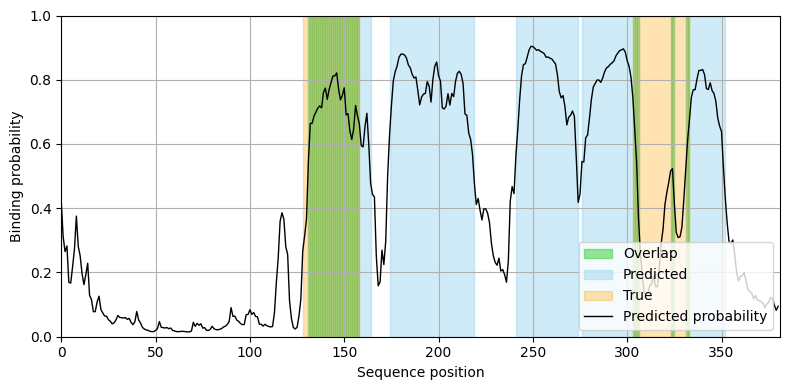

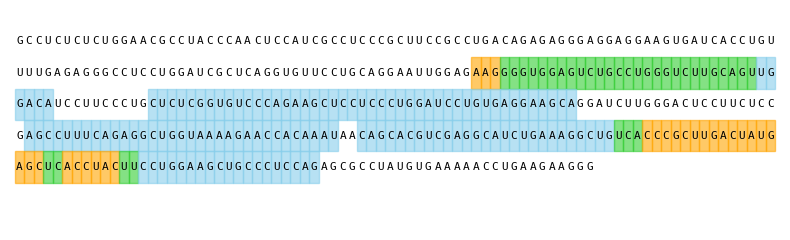

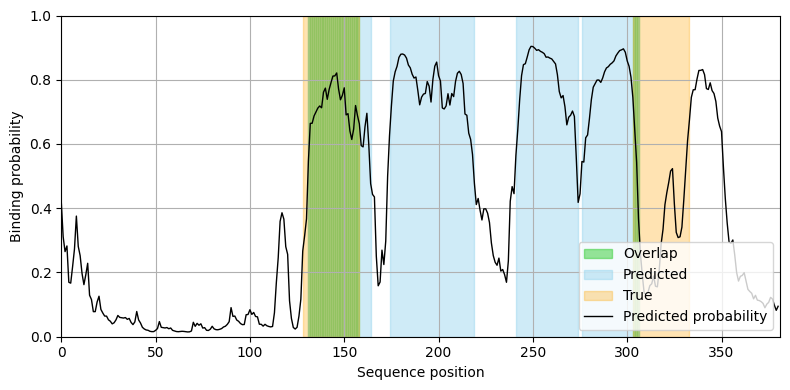

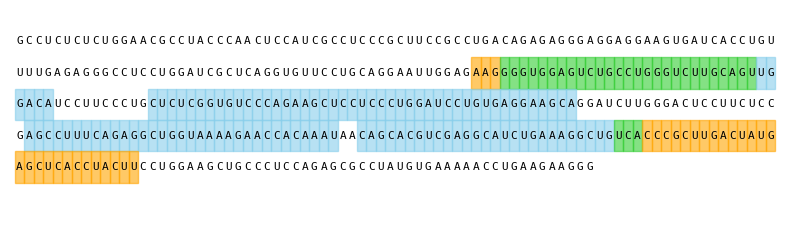

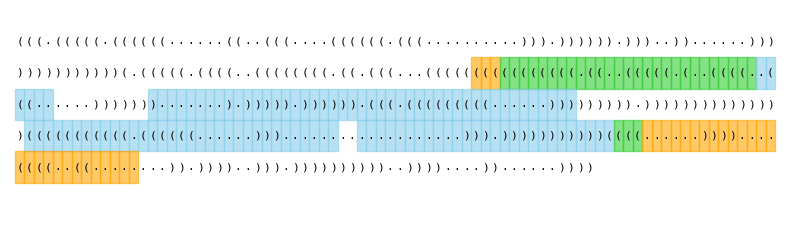

In [101]:
# idx = 62097   
# idx = 27364
# idx = 52018      
idx = 83393                       
threshold=0.5

circrna_id = df_results['isoform_ID'].iloc[idx]
mirna_seq = df_results['miRNA'].iloc[idx]
circrna_seq = df_results['circRNA'].iloc[idx]
isoform_id = df_results['isoform_ID'].iloc[idx]
try:
    structure = df_ss[df_ss['isoform_ID'] == isoform_id]['structure'].values[0]
except:
    structure = []
if len(structure) < 1:
    print('~~')
    structure, mfe, doubled_seq = predict_circRNA_structure_doubled(circrna_seq)
print(f'circRNA: {circrna_seq}')
print(f'circRNA: {structure}')
print(f'circRNA: {circrna_id}')



min_span_len = 1

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
                      
min_span_len = len(df_results['miRNA'].iloc[idx])

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)



In [64]:
df_results[df_results['isoform_ID'] == 'chr16|70127260,70128784,70128959|70127393,70128865,70129122|+']

,sample_id,binding_logits,site_logits,length_x,circRNA,isoform_ID,miRNA_ID,sites,label,binding,length_y,n_binding_site,ratio_binding_site,miRNA,target
87408,7887,"[6.93930721282959, -5.9233198165893555]","[[2.1702632904052734, -1.0171598196029663], [2...",843,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-619-5p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,28,0.073684,GCUGGGAUUACAGGCAUGAGCC,GCUGGGAUUACAGGCAUGAGCC
87409,7887,"[6.93930721282959, -5.9233198165893555]","[[2.1702632904052734, -1.0171598196029663], [2...",843,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-12114,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,27,0.071053,CAGGUGGAGGUGUGAGGUC,CAGGUGGAGGUGUGAGGUC
87410,7887,"[6.93930721282959, -5.9233198165893555]","[[2.1702632904052734, -1.0171598196029663], [2...",843,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-6882-3p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,30,0.078947,UGCUGCCUCUCCUCUUGCCUGCAG,UGCUGCCUCUCCUCUUGCCUGCAG
87411,7887,"[6.93930721282959, -5.9233198165893555]","[[2.1702632904052734, -1.0171598196029663], [2...",843,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-6808-5p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,28,0.073684,CAGGCAGGGAGGUGGGACCAUG,CAGGCAGGGAGGUGGGACCAUG
87412,7887,"[6.93930721282959, -5.9233198165893555]","[[2.1702632904052734, -1.0171598196029663], [2...",843,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-3187-5p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,56,0.147368,CCUGGGCAGCGUGUGGCUGAAGG,CCUGGGCAGCGUGUGGCUGAAGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87932,17601,"[3.576305389404297, -2.977897882461548]","[[0.42959728837013245, -0.9373035430908203], [...",624,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-608,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,29,0.076316,AGGGGUGGUGUUGGGACAGCUCCGU,AGGGGUGGUGUUGGGACAGCUCCGU
87933,17601,"[3.576305389404297, -2.977897882461548]","[[0.42959728837013245, -0.9373035430908203], [...",624,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-3059-5p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,28,0.073684,UUUCCUCUCUGCCCCAUAGGGUGU,UUUCCUCUCUGCCCCAUAGGGUGU
87934,17601,"[3.576305389404297, -2.977897882461548]","[[0.42959728837013245, -0.9373035430908203], [...",624,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-4793-3p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,28,0.073684,UCUGCACUGUGAGUUGGCUGGCU,UCUGCACUGUGAGUUGGCUGGCU
87935,17601,"[3.576305389404297, -2.977897882461548]","[[0.42959728837013245, -0.9373035430908203], [...",624,GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACU...,"chr16|70127260,70128784,70128959|70127393,7012...",hsa-miR-1249-5p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,380,27,0.071053,AGGAGGGAGGAGAUGGGCCAAGUU,AGGAGGGAGGAGAUGGGCCAAGUU


In [44]:
from Bio.Seq import Seq

def reverse_complement(seq):
    return str(Seq(seq).reverse_complement())

def classify_seed_type(miRNA_seq, circRNA_seq):
    results = []

    seed_2_7 = miRNA_seq[1:7]  # 2–7
    seed_2_8 = miRNA_seq[1:8]  # 2–8
    seed_1_7 = miRNA_seq[0:7]  # 1–7

    rc_6mer = reverse_complement(seed_2_7)
    rc_7mer = reverse_complement(seed_2_8)
    rc_7merA1 = reverse_complement(seed_2_7)
    rc_8mer = reverse_complement(seed_2_8)

    for i in range(len(circRNA_seq) - 8):
        window = circRNA_seq[i:i+8]

        if window == rc_8mer and circRNA_seq[i-1:i] == "A":
            results.append((i, "8mer"))
        elif window == rc_7mer:
            results.append((i, "7mer-m8"))
        elif window[:7] == rc_7merA1[:7] and circRNA_seq[i-1:i] == "A":
            results.append((i, "7mer-A1"))
        elif window[:6] == rc_6mer:
            results.append((i, "6mer"))

    return results


In [45]:
# miRNA_seq = "CAAAGUGCUUACAGUGCAGGUAG"  # hsa-miR-17-5p
# circRNA_seq = "AACTGATGCACTTTGAACAGTCGACTACCTGCACGTGCTTTGTTT"  # 일부 예시

matches = classify_seed_type(mirna_seq, circrna_seq)

for pos, seed_type in matches:
    print(f"Binding site at position {pos}: {seed_type}")


Binding site at position 366: 6mer


In [39]:
matches

[]

In [41]:
mirna_seq

'CAGGGAGAAGGUGGAAGUGCAGA'

In [42]:
circrna_seq

'GCUGGCUGCUGGCUCUACCAGGUUCUGUGCUGGCAUCCUGAGCACUGCCAGGCACUUGACCAUUGAGCAGAAGAUGGCAGACUACUCAAACAAACUCUACUAUCAGUUAGAGCAAGAAACAGGGAUCCAAACAGGUUACACAAGGACAGGCUCAAUCUUUCUGGCCCAAACUCAGGACCGACUGAUCUCCCUGAAGCGCAUCAACGCAGGGCUGAAUGUUAUAGGUAUCCCUUCUGAGAUCAUCUCCCCCAAGAAAGUGGCCGAGCUUCACCAUCUCCUCAACGUGCACGACCUGGUGGGGGCCAUGCAUGUUCCCGAGGAUGCAGUGGUGUCUUCCGCUGACGUGGCUCUUGCCCUGGCAAGUGCUGCCUCCCAAAAUG'

In [40]:
def compute_iou_for_sample(row, threshold=0.5, min_span_len=20):
    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    # --- IoU 계산 ---
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union > 0 else 0.0

    return iou



In [42]:
threshold = 0.5
min_span_len = 25

best = {
    'pair': [],
    'iou': [],
    'idx': [],
    'test':[]
}

ious = []
best_iou = 0.0
best_idx = -1  # 초기 인덱스 설정 (예: -1이면 아무 것도 아직 선택되지 않았다는 뜻)

for i in range(len(df_results)):
    min_span_len = len(df_results['miRNA'].iloc[i])

    iou = compute_iou_for_sample(df_results.iloc[i], threshold=threshold, min_span_len=min_span_len)
    ious.append(iou)
    print(f'\r {i}', end='\r')

    if iou > 0.6 and iou < 0.8:
        best['test'].append([i, iou])
        print(f"test match found at index {i} with IOU: {iou:.4f}")
    if iou > best_iou:
        best_iou = iou
        best_idx = i
        print(f"Best match found at index {best_idx} with IOU: {best_iou:.4f}")

# 최고 IOU가 존재할 경우 best 딕셔너리에 저장
if best_idx != -1:
    best['pair'].append([best_idx, best_iou])
    best['iou'].append(best_iou)
    best['idx'].append(best_idx)

    print(f"Best match found at index {best_idx} with IOU: {best_iou:.4f}")
else:
    print("No IOU above threshold was found.")


Best match found at index 1 with IOU: 0.1013
Best match found at index 17 with IOU: 0.1509
Best match found at index 51 with IOU: 0.1599
Best match found at index 74 with IOU: 0.1707
Best match found at index 88 with IOU: 0.2333
Best match found at index 90 with IOU: 0.2500
Best match found at index 93 with IOU: 0.3034
Best match found at index 267 with IOU: 0.3125
Best match found at index 329 with IOU: 0.4091
Best match found at index 438 with IOU: 0.5490
Best match found at index 669 with IOU: 0.8710
Best match found at index 1880 with IOU: 1.0000
test match found at index 2350 with IOU: 0.6346
test match found at index 3321 with IOU: 0.6053
test match found at index 7563 with IOU: 0.6667
test match found at index 8815 with IOU: 0.6364
test match found at index 8959 with IOU: 0.6087
test match found at index 9053 with IOU: 0.6200
test match found at index 9202 with IOU: 0.6053
test match found at index 9488 with IOU: 0.6200
test match found at index 11880 with IOU: 0.6415
test match

KeyboardInterrupt: 